<a href="https://colab.research.google.com/github/emilianodesu/SIAFI-2026-1/blob/main/ML/2_3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# 2. Machine Learning

## 2.3 Classification

### 2.3.1 MNIST Dataset

The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “hello world” of machine learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learns machine learning tackles this dataset sooner or later.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [5]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [6]:
X.shape

(70000, 784)

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [8]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

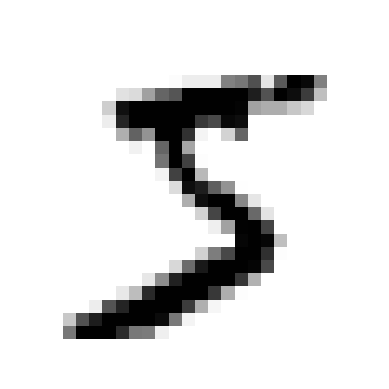

In [9]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)

plt.show()

In [10]:
y[0]

'5'

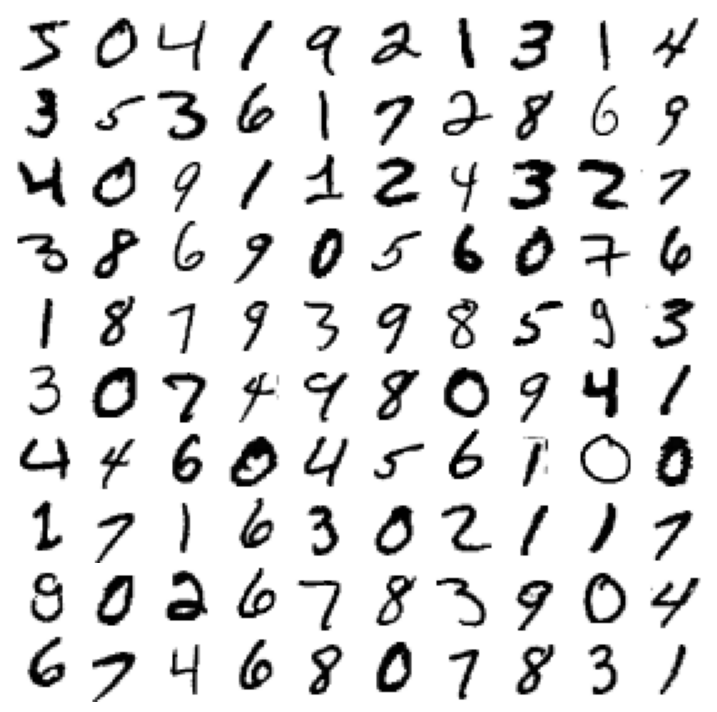

In [11]:
# extra code
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

The MNIST dataset returned by `fetch_openml()` is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images).

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (we don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 2.3.2 Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5.

In [13]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Now let’s pick a classifier and train it. A good place to start is with a stochastic gradient descent (SGD, or stochastic GD) classifier, using Scikit-Learn’s `SGDClassifier` class. This classifier is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning. Let’s create an `SGDClassifier` and train it on the whole training set:

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [15]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s performance.

### 2.3.3 Performance Measures

#### 2.3.3.1 Measuring Accuracy Using Cross-Validation

**Accuracy** is the proportion of all classifications that were correct, whether positive or negative. It is mathematically defined as:

$$\text{Accuracy} =  \frac{\text{correct classifications}}{\text{total classifications}} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

Let’s use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using k-fold cross-validation with three folds. Remember that k-fold cross-validation means splitting the training set into k folds (in this case, three), then training the model k times, holding out a different fold each time for evaluation.

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is
                                       # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.95035, 0.96035, and 0.9604

0.95035
0.96035
0.9604


Alternatively can use the `cross_val_score()` function to perform the same cross-validation more easily:

```python
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
```

Let’s look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non-5):

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

It has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with imbalanced datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

#### 2.3.3.2 Confusion Matrix

![Confusion Matrix](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/cm.png?raw=1)

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the `cross_val_predict()` function:

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (by “clean” we mean “out-of-sample”: the model makes predictions on data that it never saw during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes `(y_train_5)` and the predicted classes `(y_train_pred)`:

In [20]:
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives, also called type II errors), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [22]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

#### 2.3.3.3 Recall, Precision, FPR and F1 Score

**Recall** (also called sensitivity or true positive rate) is the proportion of all actual positive instances that were correctly classified. It is mathematically defined as:

$$\text{Recall} =  \frac{\text{correctly classified actual positives}}{\text{all actual positives}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

A hypothetical perfect model would have zero false negatives and therefore a recall (TPR) of 1.0, which is to say, a 100% detection rate.

In an imbalanced dataset where the number of actual positives is very low, recall is a more meaningful metric than accuracy because it measures the ability of the model to correctly identify all positive instances. For applications like disease prediction, correctly identifying the positive cases is crucial. A false negative typically has more serious consequences than a false positive.

**False Positive Rate (FPR)** is the proportion of all actual negatives that were classified incorrectly as positives, also known as the probability of false alarm. It is mathematically defined as:

$$\text{FPR} =  \frac{\text{incorrectly classified actual negatives}}{\text{all actual negatives}} = \frac{\text{FP}}{\text{FP} + \text{TN}}$$

A perfect model would have zero false positives and therefore a FPR of 0.0, which is to say, a 0% false alarm rate.

In an imbalanced dataset where the number of actual negatives is very, very low, say 1-2 examples in total, FPR is less meaningful and less useful as a metric.

**Precision** is the proportion of all the model's positive classifications that are actually positive. It is mathematically defined as:

$$\text{Precision} =  \frac{\text{correctly classified actual positives}}{\text{everything classified as positive}} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

A hypothetical perfect model would have zero false positives and therefore a precision of 1.0.

In an imbalanced dataset where the number of actual positives is very, very low, say 1-2 examples in total, precision is less meaningful and less useful as a metric.

Precision improves as false positives decrease, while recall improves when false negatives decrease. But as seen in the previous section, increasing the classification threshold tends to decrease the number of false positives and increase the number of false negatives, while decreasing the threshold has the opposite effects. As a result, precision and recall often show an inverse relationship, where improving one of them worsens the other.

**F1 Score** is the harmonic mean of precision and recall, providing a single metric that balances both concerns. It is mathematically defined as:

$$\text{F1} =  2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2\text{TP}}{2\text{TP}+\text{FP}+\text{FN}}$$

This metric balances the importance of precision and recall, and is preferable to accuracy for class-imbalanced datasets. When precision and recall both have perfect scores of 1.0, F1 will also have a perfect score of 1.0. More broadly, when precision and recall are close in value, F1 will be close to their value. When precision and recall are far apart, F1 will be similar to whichever metric is worse.

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

In [25]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall. Sure, the security guards will get a few false alerts, but almost all shoplifters will get caught. Similarly, medical diagnosis usually requires a high recall to avoid missing anything important. False positives can be ruled out by follow-up medical tests.

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

#### 2.3.3.4 Choice of metrics and tradeoffs

![Choice of metrics](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/metrics-choice.png?raw=1)

To understand the trade-off, let’s look at how the `SGDClassifier` makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases recall and reduces precision.

![Trade-off](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/tradeoff.png?raw=1)

Instead of calling the classifier’s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance. You can then use any threshold you want to make predictions based on those scores:

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

The `SGDClassifier` uses a threshold equal to 0, so the following code returns the same result as the `predict()` method (i.e., True). Let’s raise the threshold:

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How to decide which threshold to use? One option is to use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specifying we want to return decision scores instead of predictions:

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds (the function adds a last precision of 1 and a last recall of 0, corresponding to an infinite threshold):

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

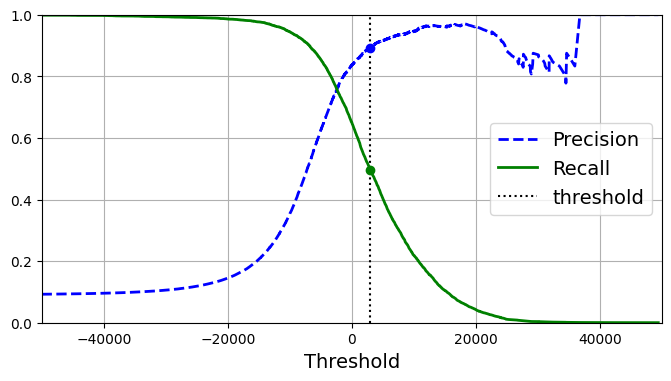

In [31]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid(True)
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

At this threshold value, precision is near 90% and recall is around 50%. Another way to select a good precision/recall trade-off is to plot precision directly against recall.

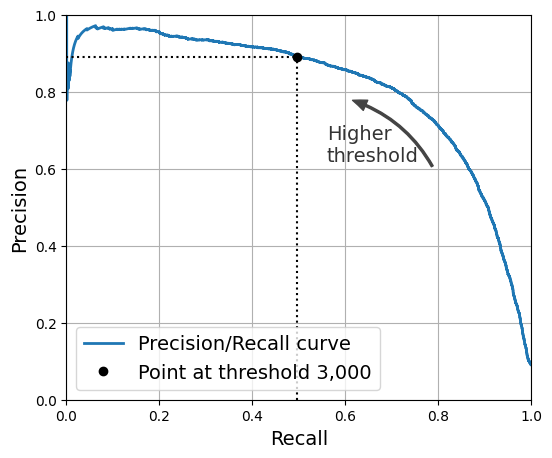

In [32]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower left")

plt.show()

You can see that precision really starts to fall sharply at around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that’s not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use the NumPy array’s argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

In [33]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [34]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast: a high-precision classifier is not very useful if its recall is too low! For many applications, 48% recall wouldn’t be great at all.

There are two classes you can use to more easily adjust the decision threshold:

* `The FixedThresholdClassifier` class lets you wrap a binary classifier and set the desired threshold manually. If the underlying classifier has a `predict_proba()` method, then the threshold should be a value between 0 and 1 (the default is 0.5). Otherwise, it should be a decision score, comparable to the output of the model’s `decision_function()` (the default is 0).

* The `TunedThresholdClassifierCV` class uses k-fold cross-validation to automatically find the optimal threshold for a given metric. By default, it tries to find the threshold that maximizes the model’s balanced accuracy: that’s the average of each class’s recall. However, you can select another metric to optimize for (see the documentation for the full list of options).

#### 2.3.3.5 ROC and AUC

The **Receiver Operating Characteristic (ROC) curve** is a visual representation of model performance across all thresholds. The long version of the name, receiver operating characteristic, is a holdover from WWII radar detection.

The ROC curve is drawn by calculating the true positive rate (TPR) and false positive rate (FPR) at every possible threshold (in practice, at selected intervals), then graphing TPR over FPR. A perfect model, which at some threshold has a TPR of 1.0 and a FPR of 0.0, can be represented by either a point at (0, 1) if all other thresholds are ignored, or by the following:

![ROC and AUC of a hypothetical perfect model](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/auc_1-0.png?raw=1)

The **area under the curve (AUC)** represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative.

The perfect model above, containing a square with sides of length 1, has an area under the curve (AUC) of 1.0. This means there is a 100% probability that the model will correctly rank a randomly chosen positive example higher than a randomly chosen negative example. In other words, looking at the spread of data points below, AUC gives the probability that the model will place a randomly chosen square to the right of a randomly chosen circle, independent of where the threshold is set.

![A spread of predictions for a binary classification model. AUC is the chance a randomly chosen square is positioned to the right of a randomly chosen circle.](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/no_slider_data.png?raw=1)

For a binary classifier, a model that does exactly as well as random guesses or coin flips has a ROC that is a diagonal line from (0,0) to (1,1). The AUC is 0.5, representing a 50% probability of correctly ranking a random positive and negative example.

![ROC and AUC of completely random guesses](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/auc_0-5.png?raw=1)

AUC is a useful measure for comparing the performance of two different models, as long as the dataset is roughly balanced. The model with greater area under the curve is generally the better one.

![ROC and AUC of two hypothetical models. The curve on the right, with a greater AUC, represents the better of the two models.](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/auc_0-65.png?raw=1)

The points on a ROC curve closest to (0,1) represent a range of the best-performing thresholds for the given model. The threshold you choose depends on which metric is most important to the specific use case. Consider the points A, B, and C in the following diagram, each representing a threshold:

![Three labeled points representing thresholds](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/auc_abc.png?raw=1)

If false positives (false alarms) are highly costly, it may make sense to choose a threshold that gives a lower FPR, like the one at point A, even if TPR is reduced. Conversely, if false positives are cheap and false negatives (missed true positives) highly costly, the threshold for point C, which maximizes TPR, may be preferable. If the costs are roughly equivalent, point B may offer the best balance between TPR and FPR.

AUC and ROC work well for comparing models when the dataset is roughly balanced between classes. When the dataset is imbalanced, precision-recall curves (PRCs) and the area under those curves may offer a better comparative visualization of model performance. Precision-recall curves are created by plotting precision on the y-axis and recall on the x-axis across all thresholds.

![PR AUC](https://github.com/emilianodesu/SIAFI-2026-1/blob/main/ML/img/prauc.png?raw=1)

To plot the ROC curve, you first use the `roc_curve()` function to compute the TPR and FPR for various threshold values:

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

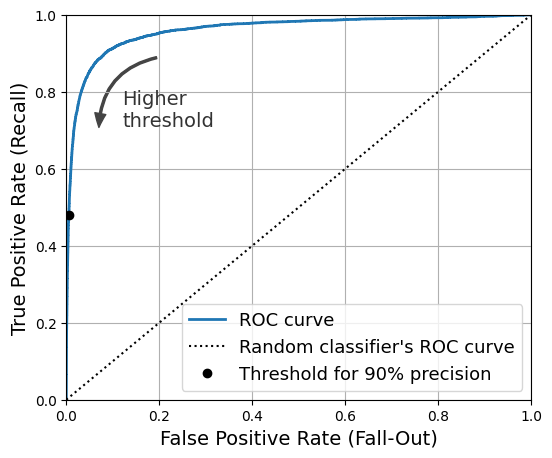

In [38]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a `RandomForestClassifier`, whose PR curve and F1 score we can compare to those of the `SGDClassifier`:

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

We can call the `cross_val_predict()` function to train the `RandomForestClassifier` using cross-validation and make it predict class probabilities for every image as follows:

In [41]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Let’s look at the estimated class probabilities for the first two images in the training set:

In [42]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the estimated probabilities in each row add up to 100%.

The second column contains the estimated probabilities for the positive class, so let’s pass them to the precision_recall_curve() function:

In [43]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

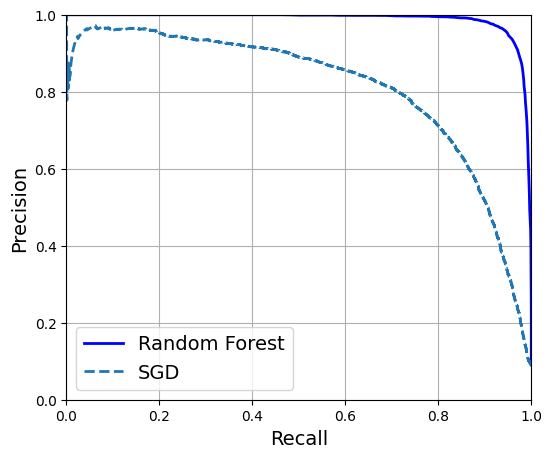

In [44]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower left")

plt.show()

The `RandomForestClassifier`’s PR curve looks much better than the `SGDClassifier`’s: it comes much closer to the top-right corner. Its F1 score and ROC AUC score are also significantly better:

In [45]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [47]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [48]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

You now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use several metrics and curves to compare various models. You’re ready to try to detect more than just the 5s.

### 2.3.4 Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some Scikit-Learn classifiers (e.g., `LogisticRegression`, `RandomForestClassifier`, and `GaussianNB`) are capable of handling multiple classes natively. Others are strictly binary classifiers (e.g., `SGDClassifier` and `SVC`). However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy, or sometimes one-versus-all (OvA).

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a support vector machine classifier using the `sklearn.svm.SVC` class:

In [49]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


We trained the SVC using the original target classes from 0 to 9 (`y_train`), instead of the 5-versus-the-rest target classes (`y_train_5`). Since there are 10 classes (i.e., more than 2), Scikit-Learn used the OvO strategy and trained 45 binary classifiers. Now let’s make a prediction on an image:

In [50]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

This code actually made 45 predictions—one per pair of classes—and it selected the class that won the most duels.⁠ If you call the `decision_function()` method, you will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak (max ±0.33) to break ties, based on the classifier scores:

In [51]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [52]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value. In the case of MNIST, the index of each class in the `classes_` array conveniently matches the class itself (e.g., the class at index 5 happens to be class '5'), but in general you won’t be so lucky; you will need to look up the class label like this:

In [53]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [54]:
svm_clf.classes_[class_id]

'5'

In [55]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

If you want to force Scikit-Learn to use `one-versus-one` or `one-versus-the-rest`, you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a classifier to its constructor (it doesn’t even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an `SVC`:

In [56]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,estimator,SVC(random_state=42)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


Let’s make a prediction, and check the number of trained classifiers:

In [57]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [58]:
len(ovr_clf.estimators_)

10

Training an `SGDClassifier` on a multiclass dataset and using it to make predictions is just as easy:

In [59]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Oops, that’s incorrect. Prediction errors do happen! This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The `decision_function()` method now returns one value per class. Let’s look at the scores that the SGD classifier assigned to each class:

In [60]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

You can see that the classifier is not very confident about its prediction: almost all scores are very negative, while class 3 has a score of +1,824, and class 5 is not too far behind at –1,386. Of course, you’ll want to evaluate this classifier on more than one image. Since there are roughly the same number of images in each class, the accuracy metric is fine. As usual, you can use the `cross_val_score()` function to evaluate the model:

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs increases accuracy above 89.1%:

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### 2.3.5 Error Analysis

If this were a real project, you would now follow the steps in your machine learning project checklist (see Intro to DS Course). You’d explore data preparation options, try out multiple models, shortlist the best ones, fine-tune their hyperparameters using `GridSearchCV`, and automate as much as possible. Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, look at the confusion matrix. For this, you first need to make predictions using the `cross_val_predict()` function; then you can pass the labels and predictions to the `confusion_matrix()` function, just like you did earlier. However, since there are now 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers, and it may be hard to read.

A colored diagram of the confusion matrix is much easier to analyze. To plot such a diagram, use the `ConfusionMatrixDisplay.from_predictions()` function like this:

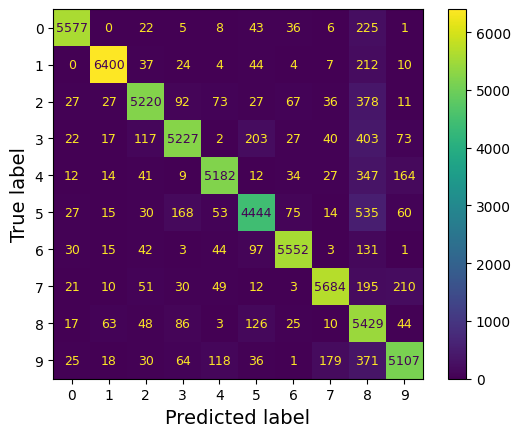

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

This confusion matrix looks pretty good: most images are on the main diagonal, which means that they were classified correctly. Notice that the cell on the diagonal in row #5 and column #5 looks slightly darker than the other digits. This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than the other digits. That’s why it’s important to normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class (i.e., divide by the row’s sum). This can be done simply by setting `normalize="true"`. We can also specify the `values_format=".0%"` argument to show percentages with no decimals.

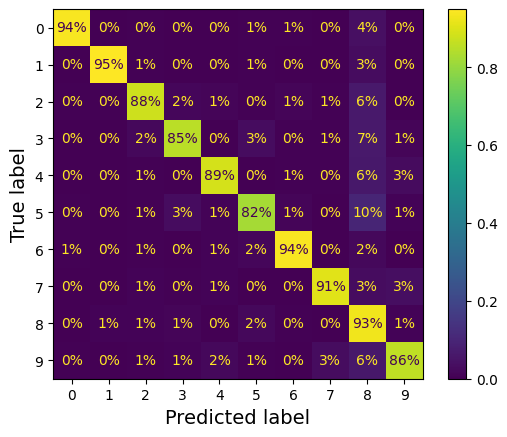

In [64]:
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

Now we can easily see that only 82% of the images of 5s were classified correctly. The most common error the model made with images of 5s was to misclassify them as 8s: this happened for 10% of all 5s. But only 2% of 8s got misclassified as 5s; confusion matrices are generally not symmetrical! If you look carefully, you will notice that many digits have been misclassified as 8s, but this is not immediately obvious from this diagram. If you want to make the errors stand out more, you can try putting zero weight on the correct predictions.

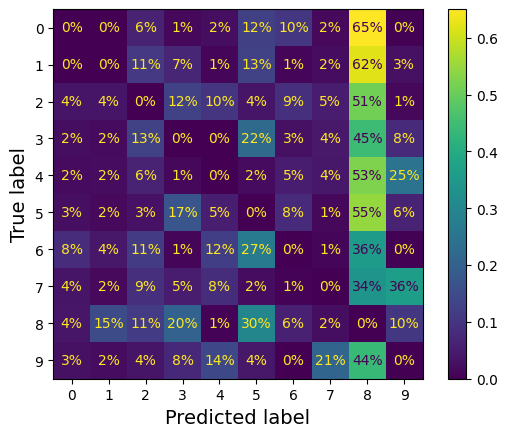

In [65]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

Now you can see much more clearly the kinds of errors the classifier makes. The column for class 8 is now really bright, which confirms that many images got misclassified as 8s. In fact this is the most common misclassification for almost all classes. But be careful how you interpret the percentages in this diagram: remember that we’ve excluded the correct predictions. For example, the 36% in row #7, column #9 in the left grid does not mean that 36% of all images of 7s were misclassified as 9s. It means that 36% of the errors the model made on images of 7s were misclassifications as 9s. In reality, only 3% of images of 7s were misclassified as 9s.

It is also possible to normalize the confusion matrix by column rather than by row: if you set `normalize="pred"`, you get the diagram below:

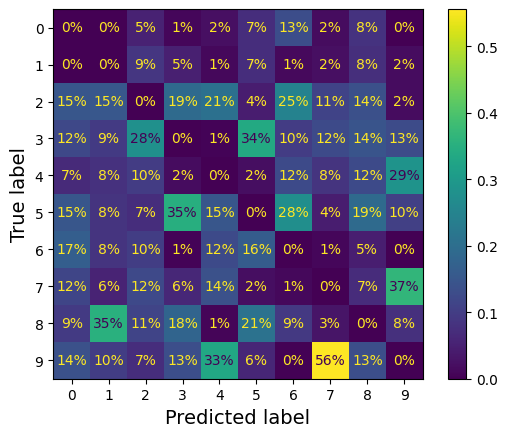

In [66]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
plt.show()

Let's put all plots in a couple of figures:

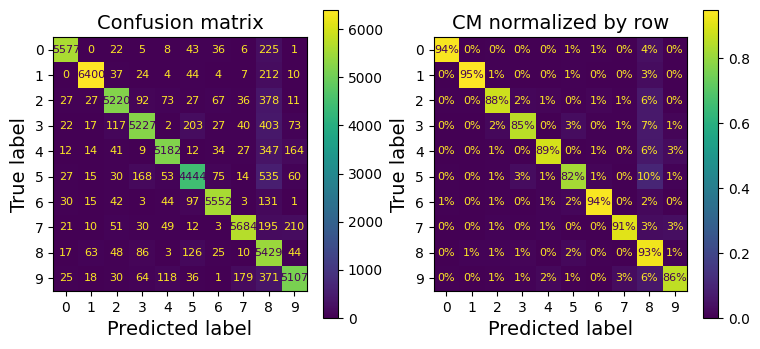

In [67]:
# extra code
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=8)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=8)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")

plt.show()

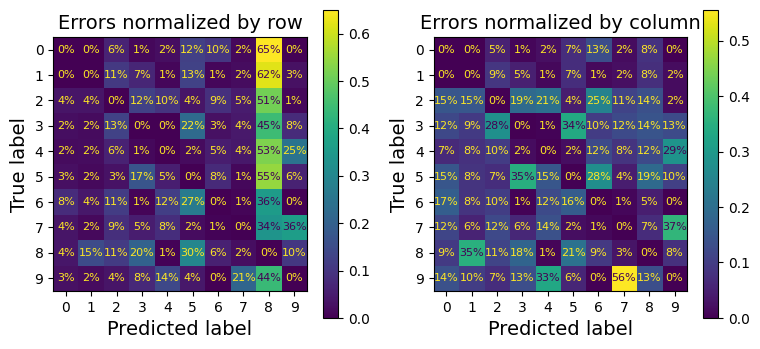

In [68]:
# extra code
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=8)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
plt.rc('font', size=8)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")

plt.show()
plt.rc('font', size=14)  # make fonts great again

Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at these plots, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.

Analyzing individual errors can also be a good way to gain insights into what your classifier is doing and why it is failing. For example, let’s plot examples of 3s and 5s in a confusion matrix style

In [69]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

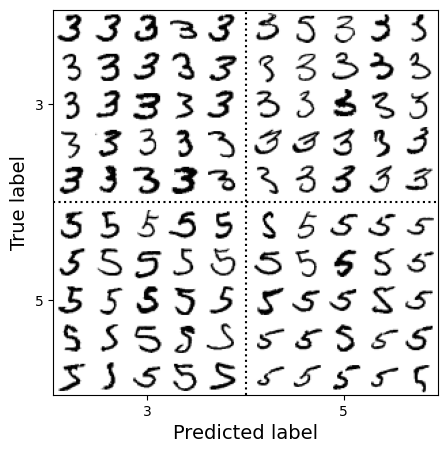

In [70]:
# extra code
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis((0, 2 * size + pad, 0, 2 * size + pad))
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

As you can see, some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them. However, most misclassified images seem like obvious errors to us. It may be hard to understand why the classifier made the mistakes it did, but remember that the human brain is a fantastic pattern recognition system, and our visual system does a lot of complex preprocessing before any information even reaches our consciousness. So, the fact that this task feels simple does not mean that it is. Recall that we used a simple `SGDClassifier`, which is just a linear model: all it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. Since 3s and 5s differ by only a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. One way to reduce the 3/5 confusion is to preprocess the images to ensure that they are well centered and not too rotated. However, this may not be easy since it requires predicting the correct rotation of each image. A much simpler approach consists of augmenting the training set with slightly shifted and rotated variants of the training images. This will force the model to learn to be more tolerant to such variations. This is called data augmentation

### 2.3.6 Multilabel Classification

Until now, each instance has always been assigned to just one class. But in some cases you may want your classifier to output multiple classes for each instance. Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces: Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output `[True, False, True]` (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is called a multilabel classification system.

We won’t go into face recognition just yet, but let’s look at a simpler example, just for illustration purposes:

In [71]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


This code creates a `y_multilabel` array containing two target labels for each digit image: the first indicates whether the digit is large (7, 8, or 9), and the second indicates whether it is odd. Then the code creates a `KNeighborsClassifier` instance, which supports multilabel classification (not all classifiers do), and trains this model using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels:

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large (`False`) and odd (`True`).

There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on your project. One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. The following code computes the average F1 score across all labels:

In [73]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [74]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

This approach assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set `average="weighted"` when calling the `f1_score()` function.

If you wish to use a classifier that does not natively support multilabel classification, such as `SVC`, one possible strategy is to train one model per label. However, this strategy may have a hard time capturing the dependencies between the labels. For example, a large digit (7, 8, or 9) is twice more likely to be odd than even, but the classifier for the “odd” label does not know what the classifier for the “large” label predicted. To solve this issue, the models can be organized in a chain: when a model makes a prediction, it uses the input features plus all the predictions of the models that come before it in the chain.

The good news is that Scikit-Learn has a class called `ClassifierChain` that does just that! By default it will use the true labels for training, feeding each model the appropriate labels depending on their position in the chain. But if you set the cv hyperparameter, it will use cross-validation to get “clean” (out-of-sample) predictions from each trained model for every instance in the training set, and these predictions will then be used to train all the models later in the chain. Note that the order of the classifiers in the chain may affect the final performance. Here’s an example showing how to create and train a `ClassifierChain` using the cross-validation strategy. As earlier, we’ll just use the first 2,000 images in the training set to speed things up:

In [75]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

,estimator,SVC()
,order,None
,cv,3
,chain_method,'predict'
,random_state,42
,verbose,False
,base_estimator,'deprecated'
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [76]:
chain_clf.predict([some_digit])

array([[0., 1.]])

### 2.3.7 Multioutput Classification

The last type of classification task we’ll discuss here is called multioutput–multiclass classification (or just multioutput classification). It is a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). This is thus an example of a multioutput classification system.

**Note**:

The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels.

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities, using a random number generator’s `integers()` method. The target images will be the original images:

In [77]:
rng = np.random.default_rng(seed=42)
noise_train = rng.integers(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise_train
noise_test = rng.integers(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

Let’s take a peek at the first image from the test set. **Yes, we’re snooping on the test data, so you should be frowning right now.**

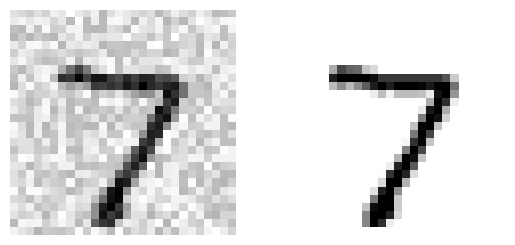

In [78]:
# extra code
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

plt.show()

On the left is the noisy input image, and on the right is the clean target image. Now let’s train the classifier and make it clean up this image:

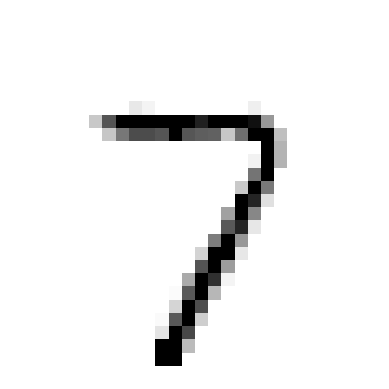

In [79]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

Looks close enough to the target! This concludes our tour of classification. You now know how to select good metrics for classification tasks, pick the appropriate precision/recall trade-off, compare classifiers, and more generally build good classification systems for a variety of tasks. In the next lesson, you’ll learn how all these machine learning models you’ve been using actually work.

---
**References:**

Disclaimer: Some of the material in this notebook is adapted from other sources. These references are provided for further reading and to acknowledge the original authors.

* Chapter 3 Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurélien Géron, [3rd edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)